In [1]:
import math
import yaml
import wandb
import xarray as xr
import asyncio
import submitit
import pickle
import sys
from pathlib import Path
import gc
from collections import defaultdict
from nilearn.connectome import sym_matrix_to_vec, vec_to_sym_matrix
import numpy as np
import pandas as pd
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import spearmanr
from sklearn.model_selection import (
    train_test_split,
)
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from tqdm.auto import tqdm
# from augmentations import augs, aug_args
import glob, os, shutil
from nilearn.datasets import fetch_atlas_schaefer_2018
import random
from sklearn.preprocessing import MinMaxScaler

from ContModeling.utils import gaussian_kernel, cauchy, standardize, save_embeddings
from ContModeling.losses import LogEuclideanLoss, NormLoss, KernelizedSupCon, OutlierRobustMSE
from ContModeling.models import PhenoProj
from ContModeling.helper_classes import MatData
from ContModeling.viz_func import wandb_plot_acc_vs_baseline, wandb_plot_test_recon_corr, wandb_plot_individual_recon

torch.cuda.empty_cache()
multi_gpu = False

In [2]:
# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [14]:
EMB_LOSSES ={
    'Norm': NormLoss(),
    'LogEuclidean': LogEuclideanLoss(),
    'MSE': nn.functional.mse_loss,
    'MSERobust': OutlierRobustMSE(),
    'Huber': nn.HuberLoss(),
    'cosine': nn.functional.cosine_embedding_loss,
}

SUPCON_KERNELS = {
    'cauchy': cauchy,
    'gaussian_kernel': gaussian_kernel,
    'None': None
    }

def train(run, train_ratio, train_dataset, test_dataset, mean, std, B_init_fMRI, cfg, model=None, device=device):
    print("Start training...")

    # MODEL DIMS
    input_dim_feat = cfg.input_dim_feat
    input_dim_target = cfg.input_dim_target
    hidden_dim = cfg.hidden_dim
    output_dim_target = cfg.output_dim_target
    output_dim_feat = cfg.output_dim_feat
    kernel = SUPCON_KERNELS[cfg.SupCon_kernel]
    
    # TRAINING PARAMS
    lr = cfg.lr
    batch_size = cfg.batch_size
    dropout_rate = cfg.dropout_rate
    weight_decay = cfg.weight_decay
    num_epochs = cfg.num_epochs

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    mean= torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    if model is None:
        model = PhenoProj(
            input_dim_feat,
            input_dim_target,
            hidden_dim,
            output_dim_target,
            output_dim_feat,
            dropout_rate,
            cfg
        ).to(device)

    if cfg.mat_ae_pretrained:
        print("Loading pretrained MatrixAutoencoder...")
        state_dict = torch.load(f"{cfg.output_dir}/{cfg.pretrained_mat_ae_exp}/saved_models/autoencoder_weights_fold{cfg.best_mat_ae_fold}.pth")
        model.matrix_ae.load_state_dict(state_dict)
        if cfg.mat_ae_freeze:
            for param in model.matrix_ae.parameters():
                param.requires_grad = False
    else:
        model.matrix_ae.enc_mat1.weight = torch.nn.Parameter(B_init_fMRI.transpose(0,1))
        model.matrix_ae.enc_mat2.weight = torch.nn.Parameter(B_init_fMRI.transpose(0,1))
    
    if cfg.reduced_mat_ae_pretrained:
        print("Loading pretrained ReducedMatrixAutoencoder...")
        state_dict = torch.load(f"{cfg.output_dir}/{cfg.pretrained_reduced_mat_ae_exp}/saved_models/autoencoder_weights_fold{cfg.best_reduced_mat_ae_fold}.pth")
        model.reduced_matrix_ae.load_state_dict(state_dict)
        if cfg.reduced_mat_ae_freeze:
            for param in model.reduced_matrix_ae.parameters():
                param.requires_grad = False

    criterion_pft = KernelizedSupCon(
        method="expw",
        temperature=cfg.pft_temperature,
        base_temperature= cfg.pft_base_temperature,
        reg_term = cfg.pft_reg_term,
        kernel=kernel,
        krnl_sigma=cfg.pft_sigma,
    )

    criterion_ptt = KernelizedSupCon(
        method="expw",
        temperature=cfg.ptt_temperature,
        base_temperature= cfg.ptt_base_temperature,
        reg_term = cfg.ptt_reg_term,
        kernel=kernel,
        krnl_sigma=cfg.ptt_sigma,
    )
    
    feature_autoencoder_crit = EMB_LOSSES[cfg.feature_autoencoder_crit]
    target_decoding_crit = EMB_LOSSES[cfg.target_decoding_crit]

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience = cfg.scheduler_patience)

    loss_terms = []
    validation = []
    autoencoder_features = []

    gc.collect()
    
    wandb.init(project=cfg.project,
        mode = "offline",
        name=f"{cfg.experiment_name}_run{run}_train_ratio_{train_ratio}",
        dir = cfg.output_dir,
        config = OmegaConf.to_container(cfg, resolve=True))

    with tqdm(range(num_epochs), desc="Epochs", leave=False) as pbar:
        for epoch in pbar:
            model.train()

            loss_terms_batch = defaultdict(lambda:0)
            for features, targets in train_loader:
                
                optimizer.zero_grad()
                features = features.to(device)
                targets = targets.to(device)

                ## FEATURE ENCODING == MATRIX REDUCTION
                embedded_feat = model.encode_features(features)
                
                ## VECTORIZE REDUCED MATRIX
                embedded_feat_vectorized = sym_matrix_to_vec(embedded_feat.detach().cpu().numpy())
                embedded_feat_vectorized = torch.tensor(embedded_feat_vectorized).to(torch.float32).to(device)

                ## EMBEDDING OF THE REDUCED MATRIX
                reduced_mat_embedding, reduced_mat_embedding_norm = model.encode_reduced_mat(embedded_feat_vectorized)

                ## RECONSTRUCT REDUCED MATRIX FROM EMBEDDING AND THE FULL MATRIX FROM REDUCED
                recon_reduced_mat = model.decode_reduced_mat(reduced_mat_embedding).detach().cpu().numpy()
                recon_reduced_mat = vec_to_sym_matrix(recon_reduced_mat)
                recon_reduced_mat = torch.tensor(recon_reduced_mat).to(torch.float32).to(device)
                reconstructed_feat = model.decode_features(recon_reduced_mat)

                ## FEATURE DECODING LOSS
                feature_autoencoder_loss = feature_autoencoder_crit(features, reconstructed_feat) / 10_000
                    
                out_target_decoded = model.decode_targets(reduced_mat_embedding_norm)

                ## KERNLIZED LOSS: MAT embedding vs targets
                kernel_embedded_target_loss, direction_reg_target = criterion_ptt(reduced_mat_embedding_norm.unsqueeze(1), targets)
                kernel_embedded_target_loss = 1000 * kernel_embedded_target_loss
                direction_reg_target = 100 * direction_reg_target

                ## LOSS: TARGET DECODING FROM TARGET EMBEDDING
                if cfg.target_decoding_crit == 'Huber' and cfg.huber_delta != 'None':
                    target_decoding_crit = nn.HuberLoss(delta = cfg.huber_delta)
                
                target_decoding_from_reduced_emb_loss = target_decoding_crit(targets, out_target_decoded) / 100


                ## SUM ALL LOSSES
                loss = target_decoding_from_reduced_emb_loss
                # print(kernel_embedded_target_loss, kernel_embedded_target_loss.type, target_decoding_from_reduced_emb_loss, target_decoding_from_reduced_emb_loss.type, direction_reg, direction_reg.type)

                if not cfg.mat_ae_pretrained:
                    loss += feature_autoencoder_loss
                    # loss += reduced_feat_loss

                loss.backward()

                if cfg.clip_grad:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    
                if cfg.log_gradients:
                    for name, param in model.named_parameters():
                        if param.grad is not None:
                            wandb.log({
                                "Epoch": epoch,
                                f"Gradient Norm/{name}": param.grad.norm().item()
                                })  

                optimizer.step()

                loss_terms_batch['loss'] = loss.item() / len(features)
                loss_terms_batch['kernel_embedded_target_loss'] = kernel_embedded_target_loss.item() / len(features)
                loss_terms_batch['target_decoding_from_reduced_emb_loss'] = target_decoding_from_reduced_emb_loss.item() / len(features)
                # loss_terms_batch['direction_reg_target_loss'] = direction_reg_target.item() / len(features)
                
                if not cfg.mat_ae_pretrained:
                    loss_terms_batch['feature_autoencoder_loss'] = feature_autoencoder_loss.item() / len(features)
                    # loss_terms_batch['reduced_feat_loss'] = reduced_feat_loss.item() / len(features)
                    wandb.log({
                        'Epoch': epoch,
                        'feature_autoencoder_loss': loss_terms_batch['feature_autoencoder_loss'],
                        # 'reduced_feat_loss': loss_terms_batch['reduced_feat_loss']
                    })
                
                wandb.log({
                    'Epoch': epoch,
                    'Run': run,
                    'total_loss': loss_terms_batch['loss'],
                    'kernel_embedded_target_loss': loss_terms_batch['kernel_embedded_target_loss'],
                    # 'direction_reg_target_loss': loss_terms_batch['direction_reg_target_loss'],
                    # 'direction_reg_features_loss': loss_terms_batch['direction_reg_features_loss'],
                    'target_decoding_from_reduced_emb_loss': loss_terms_batch['target_decoding_from_reduced_emb_loss']
                })

            loss_terms_batch['epoch'] = epoch
            loss_terms.append(loss_terms_batch)

            model.eval()
            mape_batch = 0
            corr_batch = 0
            with torch.no_grad():
                for (features, targets) in test_loader:
                    
                    features, targets = features.to(device), targets.to(device)                    
                    reduced_mat = model.encode_features(features)
                    
                    reduced_mat = torch.tensor(sym_matrix_to_vec(reduced_mat.detach().cpu().numpy())).to(torch.float32).to(device)
                    embedding, embedding_norm = model.encode_reduced_mat(reduced_mat)
                    out_target_decoded = model.decode_targets(embedding)
                    
                    epsilon = 1e-8
                    mape =  torch.mean(torch.abs((targets - out_target_decoded)) / torch.abs((targets + epsilon))) * 100
                    corr =  spearmanr(targets.cpu().numpy().flatten(), out_target_decoded.cpu().numpy().flatten())[0]
                    mape_batch+=mape.item()
                    corr_batch += corr

                mape_batch = mape_batch/len(test_loader)
                corr_batch = corr_batch/len(test_loader)
                validation.append(mape_batch)

            wandb.log({
                'Target MAPE/val' : mape_batch,
                'Target Corr/val': corr_batch,
                })
            
            scheduler.step(mape_batch)
            if np.log10(scheduler._last_lr[0]) < -4:
                break

            pbar.set_postfix_str(
                f"Epoch {epoch} "
                f"| Loss {loss_terms[-1]['loss']:.02f} "
                f"| val Target MAPE {mape_batch:.02f}"
                f"| val Target Corr {corr_batch:.02f} "
                f"| log10 lr {np.log10(scheduler._last_lr[0])}"
            )
    wandb.finish()
    loss_terms = pd.DataFrame(loss_terms)
    return loss_terms, model


In [15]:
class ModelRun(submitit.helpers.Checkpointable):
    def __init__(self):
        self.results = None
        self.embeddings = None

    def __call__(self, train, test_size, indices, train_ratio, run_size, run, dataset, cfg, random_state=None, device=None, save_model = True, path: Path = None):
        if self.results is None:
            if device is None:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                print(f"Device {device}, ratio {train_ratio}", flush=True)
            if not isinstance(random_state, np.random.RandomState):
                random_state = np.random.RandomState(random_state)

            augmentations = cfg.augmentation
            
            recon_mat_dir = os.path.join(cfg.output_dir, cfg.experiment_name, cfg.reconstructed_dir)
            os.makedirs(recon_mat_dir, exist_ok=True)
    
            predictions = {}
            autoencoder_features = {}
            losses = []
            self.embeddings = {'train': [], 'test': []}
            self.run = run

            if cfg.mat_ae_pretrained:
                print("Loading test indices from the pretraining experiment...")
                test_indices = np.load(f"{cfg.output_dir}/{cfg.pretrained_mat_ae_exp}/test_idx.npy")
                train_indices = np.setdiff1d(indices, test_indices)
                if train_ratio < 1.0:
                    train_size = int(len(train_indices) * train_ratio)
                    train_indices = random_state.choice(train_indices, train_size, replace=False)

            elif cfg.external_test_mode:
                test_scanners = list(cfg.test_scanners)
                xr_dataset = xr.open_dataset(cfg.dataset_path)
                scanner_mask = np.sum([xr_dataset.isin(scanner).scanner.values for scanner in test_scanners],
                                    axis = 0).astype(bool)
                test_indices = indices[scanner_mask]
                train_indices = indices[~scanner_mask]
                if train_ratio < 1.0:
                    train_size = int(len(train_indices) * train_ratio)
                    train_indices = random_state.choice(train_indices, train_size, replace=False)
                del xr_dataset

            else:
                run_indices = random_state.choice(indices, run_size, replace=False)
                train_indices, test_indices = train_test_split(run_indices, test_size=test_size, random_state=random_state)
                
            train_dataset = Subset(dataset, train_indices)
            test_dataset = Subset(dataset, test_indices)

            train_features = train_dataset.dataset.matrices[train_dataset.indices]
            train_targets = train_dataset.dataset.targets[train_dataset.indices].numpy()
            std_train_targets, mean, std= standardize(train_targets)
            # scaler = MinMaxScaler().fit(train_targets)
            # train_targets = scaler.transform(train_targets)

            input_dim_feat =cfg.input_dim_feat
            output_dim_feat = cfg.output_dim_feat

            ## Weight initialization for bilinear layer
            mean_f = torch.mean(train_features, dim=0).to(device)
            [D,V] = torch.linalg.eigh(mean_f,UPLO = "U")
            B_init_fMRI = V[:,input_dim_feat-output_dim_feat:] 
            test_features= test_dataset.dataset.matrices[test_dataset.indices].numpy()
            test_targets = test_dataset.dataset.targets[test_dataset.indices].numpy()
            # test_targets = scaler.transform(test_targets)

            ### Augmentation
            if augmentations != 'None':
#                 aug_params = {}
                if not isinstance(augmentations, list):
                    augmentations = [augmentations]
                n_augs = len(augmentations)
                vect_train_features = sym_matrix_to_vec(train_features, discard_diagonal=True)
                n_samples = len(train_dataset)
                n_features = vect_train_features.shape[-1]
                new_train_features = np.zeros((n_samples + n_samples * n_augs, 1, n_features))
                new_train_features[:n_samples, 0, :] = vect_train_features

                for i, aug in enumerate(augmentations):
                    transform = augs[aug]
                    transform_args = aug_args[aug]
#                     aug_params[aug] = transform_args # to save later in the metrics df

                    num_aug = i + 1
                    aug_features = np.array([transform(sample, **transform_args) for sample in train_features])
                    aug_features = sym_matrix_to_vec(aug_features, discard_diagonal=True)

                    new_train_features[n_samples * num_aug: n_samples * (num_aug + 1), 0, :] = aug_features

                train_features = new_train_features
                train_targets = np.concatenate([train_targets]*(n_augs + 1), axis=0)
            
            train_dataset = TensorDataset(train_features, torch.from_numpy(train_targets).to(torch.float32))
            test_dataset = TensorDataset(torch.from_numpy(test_features).to(torch.float32), torch.from_numpy(test_targets).to(torch.float32))

            loss_terms, model = train(run, train_ratio, train_dataset, test_dataset,mean, std, B_init_fMRI, cfg, device=device)
            losses.append(loss_terms.eval("train_ratio = @train_ratio").eval("run = @run"))

            mean = torch.tensor(mean).to(device) #do we need this?
            std  = torch.tensor(std).to(device)

            wandb.init(project=cfg.project,
                mode = "offline",
                name=f"TEST_{cfg.experiment_name}_run{run}_train_ratio_{train_ratio}",
                dir = cfg.output_dir,
                config = OmegaConf.to_container(cfg, resolve=True))
            
            embedding_dir = os.path.join(cfg.output_dir, cfg.experiment_name, cfg.embedding_dir)
            os.makedirs(embedding_dir, exist_ok=True)

            model.eval()
            with torch.no_grad():
                train_dataset = Subset(dataset, train_indices)
                train_features = train_dataset.dataset.matrices[train_dataset.indices].numpy()
                train_targets = train_dataset.dataset.targets[train_dataset.indices].numpy()
                train_dataset = TensorDataset(torch.from_numpy(train_features).to(torch.float32), torch.from_numpy(train_targets).to(torch.float32))
                std_train_targets,_,_ = standardize(train_targets)

                for label, d, d_indices in (('train', train_dataset, train_indices), ('test', test_dataset, test_indices)):
                    is_test = True
                    if label == 'train':
                        is_test = False
                    
                    X, y = zip(*d)
                    X = torch.stack(X).to(device)
                    y = torch.stack(y).to(device)
                    X_embedded = model.encode_features(X)
                    X_embedded = X_embedded.cpu().numpy()
                    X_embedded = torch.tensor(sym_matrix_to_vec(X_embedded)).to(torch.float32).to(device)
                    X_emb_reduced, X_emb_reduced_norm = model.encode_reduced_mat(X_embedded)
                    
                    if label == 'test' and train_ratio == 1.0:
                        np.save(f'{recon_mat_dir}/test_idx_run{run}',d_indices)
                        inv_feat_embedding = model.decode_reduced_mat(X_emb_reduced).detach().cpu().numpy()
                        inv_feat_embedding = vec_to_sym_matrix(inv_feat_embedding)
                        inv_feat_embedding = torch.tensor(inv_feat_embedding).to(torch.float32).to(device)
                        recon_mat = model.decode_features(inv_feat_embedding)
                        mape_mat = torch.abs((X - recon_mat) / (X + 1e-10)) * 100
                        
                        wandb_plot_test_recon_corr(wandb, cfg.experiment_name, cfg.work_dir, recon_mat.cpu().numpy(), X.cpu().numpy(), mape_mat.cpu().numpy(), True, run)
                        wandb_plot_individual_recon(wandb, cfg.experiment_name, cfg.work_dir, d_indices, recon_mat.cpu().numpy(), X.cpu().numpy(), mape_mat.cpu().numpy(), 0, True, run)

                        np.save(f'{recon_mat_dir}/recon_mat_run{run}', recon_mat.cpu().numpy())
                        np.save(f'{recon_mat_dir}/mape_mat_run{run}', mape_mat.cpu().numpy())
                    y_pred = model.decode_targets(X_emb_reduced_norm)

                    save_embeddings(X_embedded, "mat", cfg, is_test, run)
                    save_embeddings(X_emb_reduced_norm, "joint", cfg, is_test, run)

                    if label == 'test':
                        epsilon = 1e-8
                        mape =  100 * torch.mean(torch.abs((y - y_pred)) / torch.abs((y + epsilon))).item()
                        corr =  spearmanr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0]

                        wandb.log({
                            'Run': run,
                            'Test | Target MAPE/val' : mape,
                            'Test | Target Corr/val': corr,
                            'Test | Train ratio' : train_ratio
                            })
            
                    predictions[(train_ratio, run, label)] = (y.cpu().numpy(), y_pred.cpu().numpy(), d_indices)
                    for i, idx in enumerate(d_indices):
                        self.embeddings[label].append({
                            'index': idx,
                            'joint_embedding': X_emb_reduced[i].cpu().numpy()
                        })
            wandb.finish()
            
            self.results = (losses, predictions, self.embeddings)

        if save_model:
            saved_models_dir = os.path.join(cfg.output_dir, cfg.experiment_name, cfg.model_weight_dir)
            os.makedirs(saved_models_dir, exist_ok=True)
            torch.save(model.state_dict(), f"{saved_models_dir}/model_weights_run{run}.pth")

        return self.results

    def checkpoint(self, *args, **kwargs):
        print("Checkpointing", flush=True)
        return super().checkpoint(*args, **kwargs)

In [24]:
with initialize(version_base=None, config_path="."):
    cfg = compose(config_name='main_model_config.yaml')
    print(OmegaConf.to_yaml(cfg))

project: PhenProj
experiment_name: inv_sup_embed_full
hypothesis: '-'
input_dim_feat: 400
output_dim_feat: 100
hidden_dim: 128
input_dim_target: 1
output_dim_target: 64
skip_enc1: false
ReEig: false
mat_ae_pretrained: true
reduced_mat_ae_pretrained: true
mat_ae_freeze: true
reduced_mat_ae_freeze: true
pretrained_mat_ae_exp: ext_mat_ae_abcd
pretrained_reduced_mat_ae_exp: ext_sup_reduced_mat_ae_abcd
best_mat_ae_fold: 4
best_reduced_mat_ae_fold: 4
synth_exp: false
multi_gpu: true
num_epochs: 100
batch_size: 128
n_runs: 1
lr: 0.001
weight_decay: 0
dropout_rate: 0
scheduler_patience: 10
test_ratio: 0.3
train_ratio: 1.0
log_gradients: true
clip_grad: true
external_test_mode: true
test_scanners:
- GE MEDICAL SYSTEMS_DISCOVERY MR750
- Philips Medical Systems_Achieva dStream
- Philips Medical Systems_Ingenia
SupCon_kernel: cauchy
SupConLoss_on_mat: false
pft_base_temperature: 0.07
pft_temperature: 0.07
pft_sigma: 1
pft_reg_term: 0.01
ptt_base_temperature: 0.07
ptt_temperature: 0.07
ptt_sigma: 1

In [28]:
results_path = cfg.output_dir
data_path = cfg.dataset_path

# MODEL DIMS
input_dim_feat = cfg.input_dim_feat
input_dim_target = cfg.input_dim_target
hidden_dim = cfg.hidden_dim
output_dim_target = cfg.output_dim_target
output_dim_feat = cfg.output_dim_feat
# kernel = SUPCON_KERNELS[cfg.SupCon_kernel]

# TRAINING PARAMS
lr = cfg.lr
batch_size = cfg.batch_size
dropout_rate = cfg.dropout_rate
weight_decay = cfg.weight_decay
num_epochs = cfg.num_epochs

In [95]:
from ContModeling.models import ReducedMatAutoEncoder

model = ReducedMatAutoEncoder(
    output_dim_feat,
    hidden_dim,
    output_dim_target,
    dropout_rate,
    cfg
).to(device)
state_dict = torch.load(f"{results_path}/ext_reduced_mat_ae_abcd/saved_models/autoencoder_weights_fold4.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

/tmp/ipykernel_2548973/581966125.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{results_path}/ext_reduced_mat_ae_abcd/saved_models/autoencod

ReducedMatAutoEncoder(
  (reduced_mat_to_embed): Sequential(
    (0): Linear(in_features=5050, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
  )
  (embed_to_reduced_mat): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p

In [92]:
model = PhenoProj(
    input_dim_feat,
    input_dim_target,
    hidden_dim,
    output_dim_target,
    output_dim_feat,
    dropout_rate,
    cfg
).to(device)
state_dict = torch.load(f"{results_path}/{cfg.experiment_name}/saved_models/model_weights_run0.pth", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()


/tmp/ipykernel_2548973/86431507.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{results_path}/{cfg.experiment_name}/saved_models/model_weight

PhenoProj(
  (matrix_ae): MatAutoEncoder(
    (enc_mat1): Linear(in_features=400, out_features=100, bias=False)
    (enc_mat2): Linear(in_features=400, out_features=100, bias=False)
    (dec_mat1): Linear(in_features=100, out_features=400, bias=False)
    (dec_mat2): Linear(in_features=100, out_features=400, bias=False)
    (dropout): Dropout(p=0, inplace=False)
  )
  (reduced_matrix_ae): ReducedMatAutoEncoder(
    (reduced_mat_to_embed): Sequential(
      (0): Linear(in_features=5050, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ELU(alpha=1.0)
      (7): Dropout(p=0, inplace=False)
      (8): Linear(in_features=128, out_features=128, bias=True)
      (9): BatchNorm1d(128, eps=1e-05,

In [29]:
dataset = xr.open_dataset(data_path)
matrix = dataset.matrices.isel(subject = 100).values

[]

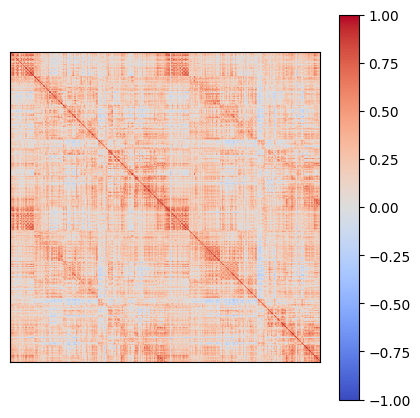

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(matrix, cmap='coolwarm', vmax=1, vmin=-1)
plt.colorbar()
ax.set_xticks([])
ax.set_yticks([])

In [83]:
matrix_tensor = torch.Tensor(matrix)
enc_mat_1 = model.matrix_ae.enc_mat1(matrix_tensor.to(device))

[]

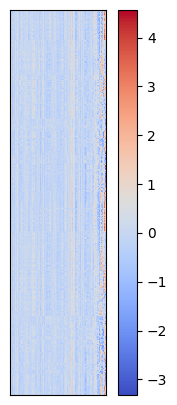

In [84]:
fig, ax = plt.subplots(figsize=(3, 5))
plt.imshow(enc_mat_1.cpu().detach().numpy(), cmap='coolwarm')
plt.colorbar()
ax.set_xticks([])
ax.set_yticks([])


In [85]:
enc_mat_2 = model.matrix_ae.enc_mat2(enc_mat_1.permute(1, 0))


[]

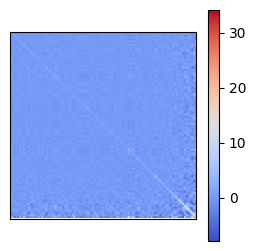

In [86]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(enc_mat_2.cpu().detach().numpy(), cmap='coolwarm')
plt.colorbar()
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
reduced_mat

tensor([[ 1.9626,  0.3885,  0.7813,  ..., 12.2531, -1.6329, 24.1746]],
       device='cuda:0')

In [96]:
reduced_mat = torch.tensor(sym_matrix_to_vec(enc_mat_2.unsqueeze(0).detach().cpu().numpy())).to(torch.float32).to(device)
embedding, embedding_norm = model.embed_reduced_mat(reduced_mat)
recon_reduced_mat = model.recon_reduced_mat(embedding)
recon_reduced_mat = vec_to_sym_matrix(recon_reduced_mat.detach().cpu().numpy())
recon_reduced_mat = torch.tensor(recon_reduced_mat).to(torch.float32).to(device)


In [97]:
recon_reduced_mat

tensor([[[ 2.9764e+00,  4.1933e-01, -8.0253e-01,  ..., -1.9930e+00,
          -5.0069e+00,  3.1078e-01],
         [ 4.1933e-01,  8.8302e-01, -6.4588e-01,  ...,  9.3283e-01,
          -6.6214e-03,  8.3301e-01],
         [-8.0253e-01, -6.4588e-01,  1.8135e+00,  ..., -1.9392e+00,
           1.3164e+00, -1.3918e+00],
         ...,
         [-1.9930e+00,  9.3283e-01, -1.9392e+00,  ...,  1.4948e+01,
           1.1821e+00,  3.4567e+00],
         [-5.0069e+00, -6.6214e-03,  1.3164e+00,  ...,  1.1821e+00,
           1.7511e+01, -1.9979e-01],
         [ 3.1078e-01,  8.3301e-01, -1.3918e+00,  ...,  3.4567e+00,
          -1.9979e-01,  2.0981e+00]]], device='cuda:0')

[]

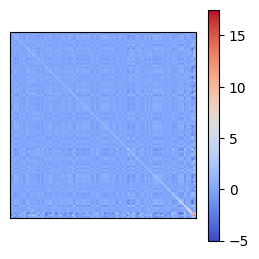

In [98]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.imshow(recon_reduced_mat.cpu().detach().numpy()[0], cmap='coolwarm')
plt.colorbar()
ax.set_xticks([])
ax.set_yticks([])

In [91]:
recon_reduced_mat.shape

torch.Size([1, 100, 100])

In [93]:
dec_mat_1 = model.matrix_ae.dec_mat1(recon_reduced_mat[0]).permute(1, 0)
dec_mat_2 = model.matrix_ae.dec_mat2(dec_mat_1)

[]

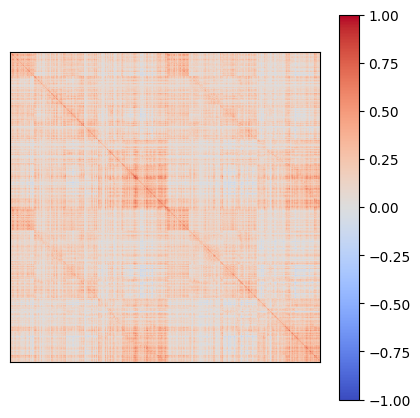

In [94]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.imshow(dec_mat_2.cpu().detach().numpy(), cmap='coolwarm', vmax=1, vmin=-1)
plt.colorbar()
ax.set_xticks([])
ax.set_yticks([])

In [16]:
# test_ratio = 0.3
# train_ratio = 1.0
# dataset_path = "/gpfs3/well/margulies/users/cpy397/contrastive-learning/data/abcd_dataset_400parcels_1.nc"
# dataset = MatData(dataset_path, ["nihtbx_totalcomp_agecorrected"], synth_exp = False, threshold=0)
# n_sub = len(dataset)
# indices = np.arange(n_sub)
# train_size = int(n_sub * (1 - test_ratio) * train_ratio)
# test_size = int(test_ratio * n_sub)
# run_size = test_size + train_size
# random_state = np.random.RandomState(seed=42)
# run_indices = random_state.choice(indices, run_size, replace=False)
# train_indices, test_indices = train_test_split(run_indices, test_size=0.3, random_state=random_state)
# train_dataset = Subset(dataset, train_indices)
# test_dataset = Subset(dataset, test_indices)


In [17]:
# train_features = train_dataset.dataset.matrices[train_dataset.indices]
# train_targets = train_dataset.dataset.targets[train_dataset.indices].numpy()
# std_train_targets, mean, std= standardize(train_targets)
# # scaler = MinMaxScaler().fit(train_targets)
# # train_targets = scaler.transform(train_targets)

# input_dim_feat =cfg.input_dim_feat
# output_dim_feat = cfg.output_dim_feat

# ## Weight initialization for bilinear layer
# mean_f = torch.mean(train_features, dim=0).to(device)
# [D,V] = torch.linalg.eigh(mean_f,UPLO = "U")
# B_init_fMRI = V[:,input_dim_feat-output_dim_feat:] 
# test_features= test_dataset.dataset.matrices[test_dataset.indices].numpy()
# test_targets = test_dataset.dataset.targets[test_dataset.indices].numpy()

In [18]:
# train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=228, shuffle=True)

In [19]:
# model = PhenoProj(
#     cfg.input_dim_feat,
#     cfg.input_dim_target,
#     cfg.hidden_dim,
#     cfg.output_dim_target,
#     cfg.output_dim_feat,
#     cfg.dropout_rate,
#     cfg
# ).to(device)

In [20]:
# matrices = train_loader.dataset.dataset.matrices[:3]
# matrices = matrices.to(device)
# targets = train_loader.dataset.dataset.targets[:3]
# targets = targets.to(device)

In [21]:
# input_dim_feat=cfg.input_dim_feat,
# input_dim_target=cfg.input_dim_target,
# hidden_dim=cfg.hidden_dim,
# output_dim_target=cfg.output_dim_target,
# output_dim_feat=cfg.output_dim_feat,
# dropout_rate=cfg.dropout_rate,

# enc_mat1 = nn.Linear(in_features=400, out_features=70 ,bias=False)
# enc_mat2 = nn.Linear(in_features=400, out_features=70, bias=False)

# enc_mat1.weight = torch.nn.Parameter(B_init_fMRI.transpose(0,1))
# enc_mat2.weight = torch.nn.Parameter(B_init_fMRI.transpose(0,1))

# enc_mat1.weight = torch.nn.Parameter(B_init_fMRI.transpose(0,1))
# enc_mat2.weight = torch.nn.Parameter(enc_mat1.weight)


In [22]:
with initialize(version_base=None, config_path="."):
    cfg = compose(config_name='main_model_config.yaml')
    print(OmegaConf.to_yaml(cfg))

project: PhenProj
experiment_name: inv_sup_embed_full
hypothesis: '-'
input_dim_feat: 400
output_dim_feat: 100
hidden_dim: 128
input_dim_target: 1
output_dim_target: 64
skip_enc1: false
ReEig: false
mat_ae_pretrained: true
reduced_mat_ae_pretrained: true
mat_ae_freeze: true
reduced_mat_ae_freeze: true
pretrained_mat_ae_exp: ext_mat_ae_abcd
pretrained_reduced_mat_ae_exp: ext_sup_reduced_mat_ae_abcd
best_mat_ae_fold: 4
best_reduced_mat_ae_fold: 4
synth_exp: false
multi_gpu: true
num_epochs: 100
batch_size: 128
n_runs: 1
lr: 0.001
weight_decay: 0
dropout_rate: 0
scheduler_patience: 10
test_ratio: 0.3
train_ratio: 1.0
log_gradients: true
clip_grad: true
external_test_mode: true
test_scanners:
- GE MEDICAL SYSTEMS_DISCOVERY MR750
- Philips Medical Systems_Achieva dStream
- Philips Medical Systems_Ingenia
SupCon_kernel: cauchy
SupConLoss_on_mat: false
pft_base_temperature: 0.07
pft_temperature: 0.07
pft_sigma: 1
pft_reg_term: 0.01
ptt_base_temperature: 0.07
ptt_temperature: 0.07
ptt_sigma: 1

In [23]:
def main(cfg=cfg):

    results_dir = os.path.join(cfg.output_dir, cfg.experiment_name)
    os.makedirs(results_dir, exist_ok=True)

    random_state = np.random.RandomState(seed=42)

    dataset_path = cfg.dataset_path

    if isinstance(cfg.targets, str):
        
        targets =[cfg.targets]
    else:
        targets = list(cfg.targets)
        
    test_ratio = cfg.test_ratio

    dataset = MatData(dataset_path, targets, synth_exp = cfg.synth_exp, threshold=cfg.mat_threshold)
    n_sub = len(dataset)
    test_size = int(test_ratio * n_sub)
    indices = np.arange(n_sub)
    n_runs = cfg.n_runs
    multi_gpu = False
    train_ratio = cfg.train_ratio
    
    multi_gpu = False
    if multi_gpu:
        print("Using multi-gpu")
        log_folder = Path("logs")
        executor = submitit.AutoExecutor(folder=str(log_folder / "%j"))
        executor.update_parameters(
            timeout_min=120,
            slurm_partition="gpu_short",
            gpus_per_node=1,
            tasks_per_node=1,
            nodes=1
            #slurm_constraint="v100-32g",
        )
        run_jobs = []

        with executor.batch():
            train_size = int(n_sub * (1 - test_ratio) * train_ratio)
            run_size = test_size + train_size
            for run in tqdm(range(n_runs)):
                run_model = ModelRun()
                job = executor.submit(run_model, train, test_size, indices, train_ratio, run_size, run, dataset, cfg, random_state=random_state, device=None)
                run_jobs.append(job)

        async def get_result(run_jobs):
            run_results = []
            for aws in tqdm(asyncio.as_completed([j.awaitable().result() for j in run_jobs]), total=len(run_jobs)):
                res = await aws
                run_results.append(res)
            return run_results
        run_results = asyncio.run(get_result(run_jobs))

    else:
        run_results = []
        train_size = int(n_sub * (1 - test_ratio) * train_ratio)
        run_size = test_size + train_size
        for run in tqdm(range(n_runs), desc="Model Run"):
            run_model = ModelRun()
            job = run_model(train, test_size, indices, train_ratio, run_size, run, dataset, cfg, random_state=random_state, device=None)
            run_results.append(job)

    losses, predictions, embeddings = zip(*run_results)

    prediction_metrics = predictions[0]
    for prediction in predictions[1:]:
        prediction_metrics.update(prediction)

    pred_results = []
    for k, v in prediction_metrics.items():
        true_targets, predicted_targets, indices = v
        
        true_targets_dict = {"train_ratio": [k[0]] * len(true_targets),
                             "model_run":[k[1]] * len(true_targets),
                             "dataset":[k[2]] * len(true_targets)
                            }
        predicted_targets_dict = {"indices": indices}
        
        for i, target in enumerate(targets):
            true_targets_dict[target] = true_targets[:, i]
            predicted_targets_dict[f"{target}_pred"] = predicted_targets[:, i]
            
            
        true_targets = pd.DataFrame(true_targets_dict)
        predicted_targets = pd.DataFrame(predicted_targets_dict)
        
        pred_results.append(pd.concat([true_targets, predicted_targets], axis = 1))
    pred_results = pd.concat(pred_results)
    pred_results.to_csv(f"{results_dir}/pred_results.csv", index=False)

    prediction_mape_by_element = []
    for k, v in prediction_metrics.items():
        true_targets, predicted_targets, indices = v
        
        mape_by_element = np.abs(true_targets - predicted_targets) / (np.abs(true_targets)+1e-10)
        
        for i, mape in enumerate(mape_by_element):
            prediction_mape_by_element.append(
                {
                    'train_ratio': k[0],
                    'model_run': k[1],
                    'dataset': k[2],
                    'mape': mape
                }
            )

    df = pd.DataFrame(prediction_mape_by_element)
    df = pd.concat([df.drop('mape', axis=1), df['mape'].apply(pd.Series)], axis=1)
    df.columns = ['train_ratio', 'model_run', 'dataset'] + targets
    df= df.groupby(['train_ratio', 'model_run', 'dataset']).agg('mean').reset_index()
    df.to_csv(f"{results_dir}/mape.csv", index = False)

if __name__ == "__main__":
    main()

Model Run:   0%|          | 0/1 [00:00<?, ?it/s]

Device cuda, ratio 1.0
Loading test indices from the pretraining experiment...
Start training...
Loading pretrained MatrixAutoencoder...
Loading pretrained ReducedMatrixAutoencoder...


/tmp/ipykernel_2548973/1139184495.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{cfg.output_dir}/{cfg.pretrained_mat_ae_exp}/saved_models/au

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇██
Gradient Norm/target_dec.decode_target.0.bias,▁▁▁▂▄▃▂▃▂▂▃▆▄▅▆▂▂▃▃▃▄▃▄▃▄▆▇▅█▅█▄▇▅▄▅▅▆▆▄
Gradient Norm/target_dec.decode_target.0.weight,▁▁▁▁▁▃▅▄▄▄▄▃▆▄▄▃▅▃▇█▄▄▆▄▃▄▇▄▇▄▇▆▄▄▆▆▇▅▅▅
Gradient Norm/target_dec.decode_target.1.bias,▁▁▁▁▂▃▁▂▂▃▅▃▂▃▂▆▃▂▆▄▅▃▄▄▆█▃▄▅▅▅▆▅▃▄▄▅▅▅▆
Gradient Norm/target_dec.decode_target.1.weight,▁▁▁▁▁▃▁▂▃▄▅▄▇▂▇▄█▄▇▆▇▇▅▄▅▅▄▅▇▅▄▃▅▃▅▄▃▇█▆
Gradient Norm/target_dec.decode_target.12.bias,█▇▆▆▅▄▅▄▄▄▃▃▃▃▃▃▂▂▂▃▁▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▂▂▁▂
Gradient Norm/target_dec.decode_target.12.weight,▇▇████▇▇▇▇▇▅▇▇▇▆▆▇▅▄▅▇▃▆▆▆▇▅▁▂▆▅▅▆▄▆▁▆▂▄
Gradient Norm/target_dec.decode_target.4.bias,▁▁▁▁▁▁▂▂▂▂▃▂▄▄▂▃▃▃▄▄▃▅▅▅▆▇▅▆█▆▄▇▅▅▄▄▇▄▅▆
Gradient Norm/target_dec.decode_target.4.weight,▁▂▁▁▂▁▂▁▄▄▂▂▄▄▃▂▃▅▃▇█▇▃▃▅▇▄▆▇█▇▅▆▆▄▅▄▅▇▄
Gradient Norm/target_dec.decode_target.5.bias,▁▁▂▁▂▂▁▂▃▂▃▅▄▆▃▂▄▇▄▅▄█▅▆▇▅▆▃▄▃▅▄▃▄▃▄▅▅▃▅
Gradient Norm/target_dec.decode_target.5.weight,▁▁▁▁▁▁▂▁▁▄▁▃▃▄▅▂▄▄▃▃▄▂██▅▅▅▄▃▇▅▄▅▄▃▄█▅▄▄


/home/mind/vshevche/contrastive-learning/contrastive_phenotypes/src/ContModeling/viz_func.py:107: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations[i // cols, i % cols] = spearmanr(flat_true[:, i], flat_recon[:, i])[0]


Run,▁
Test | Target Corr/val,▁
Test | Target MAPE/val,▁
Test | Train ratio,▁
Run,0
Test | Target Corr/val,0.19212
Test | Target MAPE/val,58.47009
Test | Train ratio,1
